### Лабораторная работа №6 (Проведение исследований с моделями классификации)

## 1. Выбор начальных условий

# Выбор датасета
Данные https://www.kaggle.com/datasets/gpiosenka/tree-nuts-image-classification

Я выбрала датасет, который содержит фотографии орехов, поделенные на классы.   
Обученная модель поможет автоматически сортировать орехи на производстве:
 - ускорить контроль качества на конвейере  
 - сократить долю ручного труда и человеческих ошибок  
 - обеспечить правильную рецептуру и безопасность (предотвращение смешивания аллергенных орехов)  

In [14]:
!pip install kaggle
!pip install opendatasets
!pip install pandas


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/gpiosenka/tree-nuts-image-classification")

Skipping, found downloaded files in ".\tree-nuts-image-classification" (use force=True to force download)


Найдено классов: 10 - ['almonds', 'brazil nuts', 'cashews', 'coconut', 'hazelnuts', 'macadamia', 'pecans', 'pine nuts', 'pistachios', 'walnuts']


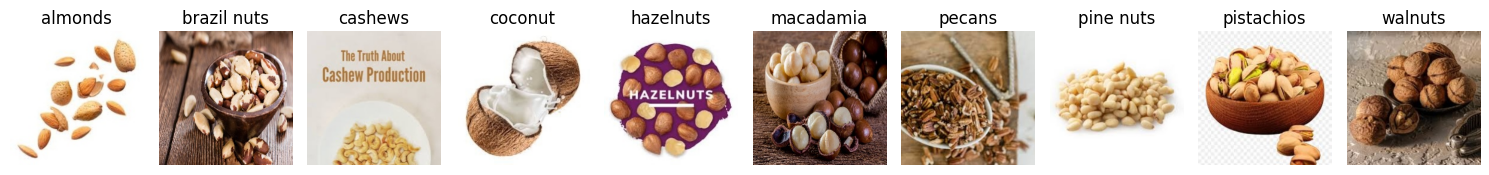

In [16]:
import os
import glob
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


data_dir = 'c:/Users/Anna/Downloads/multi_sem2/tree-nuts-image-classification/train'



classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
print(f"Найдено классов: {len(classes)} - {classes}")


sample_images = []
sample_labels = []
for cls in classes:
    img_paths = glob.glob(os.path.join(data_dir, cls, '*.jpg'))
    if img_paths:
        sample_img = random.choice(img_paths)
        sample_images.append(sample_img)
        sample_labels.append(cls)


n_classes = len(sample_images)


plt.figure(figsize=(15, 5))
for i, (img_path, label) in enumerate(zip(sample_images, sample_labels)):
    plt.subplot(1, n_classes, i+1)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()


# 2. Метрики качества  
Для оценки качества модели используем две основные метрики:  

 - Accuracy = (TP + TN) / (TP + TN + FP + FN), показывающую долю корректных предсказаний от общего числа изображений;  

 - F1-score = 2·(Precision · Recall) / (Precision + Recall), позволяющий более точно учесть баланс между Precision и Recall в каждом классе.  

Дополнительно будем строить матрицу ошибок (Confusion Matrix), чтобы визуально выявить пары классов, которые модель путает наиболее часто, и на основе этого скорректировать гиперпараметры или усилить аугментации.  

## Создание бейзлана и оценка качества


In [17]:
!pip install seaborn


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import torch
print("CUDA:", torch.cuda.is_available()) 
print("Devices:", torch.cuda.device_count()) 
print("GPU name:", torch.cuda.get_device_name(0)) 


CUDA: True
Devices: 1
GPU name: NVIDIA GeForce RTX 3060


In [18]:
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import random_split, DataLoader

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix  # уже есть

# Трансформации для train/val
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

data_dir = 'c:/Users/Anna/Downloads/multi_sem2/tree-nuts-image-classification/train'
full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms)
print(f"Всего изображений: {len(full_dataset)}")
print(f"Классы: {full_dataset.classes}")

# Сплит на train/val
train_size = int(0.8 * len(full_dataset))
val_size   = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

batch_size = 32
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=4),
    'val':   DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4)
}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names    = full_dataset.classes
num_classes    = len(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Используем устройство: {device}")


Всего изображений: 1163
Классы: ['almonds', 'brazil nuts', 'cashews', 'coconut', 'hazelnuts', 'macadamia', 'pecans', 'pine nuts', 'pistachios', 'walnuts']
Используем устройство: cuda:0


In [34]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_preds = []
    best_labels = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        epoch_preds = {'train': [], 'val': []}
        epoch_labels = {'train': [], 'val': []}

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                epoch_preds[phase].extend(preds.cpu().numpy())
                epoch_labels[phase].extend(labels.cpu().numpy())

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc  = running_corrects.double() / dataset_sizes[phase]
            epoch_f1   = f1_score(epoch_labels[phase],
                                  epoch_preds[phase],
                                  average='weighted')

            print(f'{phase:5} | Loss: {epoch_loss:.4f}  '
                  f'Acc: {epoch_acc:.4f}  '
                  f'F1:  {epoch_f1:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_preds = epoch_preds['val'].copy()
                best_labels = epoch_labels['val'].copy()

        print()

    time_elapsed = time.time() - since
    print(f'Обучение завершено за {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Лучшая точность на валидации: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, best_preds, best_labels



Будем использовать модель ResNet-18, так как она остаётся достаточно компактной и быст­рой в обучении, что важно для ограниченных вычислительных ресурсов.

Using device: cuda
Epoch 1/10
----------


c:\Users\Anna\Downloads\multi_sem2\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Anna\Downloads\multi_sem2\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


train | Loss: 2.1132  Acc: 0.2473  F1:  0.2319
val   | Loss: 1.7457  Acc: 0.4378  F1:  0.4221

Epoch 2/10
----------
train | Loss: 1.4244  Acc: 0.5839  F1:  0.5796
val   | Loss: 1.1477  Acc: 0.6609  F1:  0.6572

Epoch 3/10
----------
train | Loss: 1.0374  Acc: 0.6957  F1:  0.6956
val   | Loss: 0.9707  Acc: 0.6953  F1:  0.6938

Epoch 4/10
----------
train | Loss: 0.8430  Acc: 0.7538  F1:  0.7518
val   | Loss: 0.8411  Acc: 0.7425  F1:  0.7413

Epoch 5/10
----------
train | Loss: 0.7225  Acc: 0.7882  F1:  0.7881
val   | Loss: 0.8013  Acc: 0.7339  F1:  0.7320

Epoch 6/10
----------
train | Loss: 0.6128  Acc: 0.8226  F1:  0.8223
val   | Loss: 0.6812  Acc: 0.7768  F1:  0.7746

Epoch 7/10
----------
train | Loss: 0.5423  Acc: 0.8581  F1:  0.8575
val   | Loss: 0.7556  Acc: 0.7639  F1:  0.7629

Epoch 8/10
----------
train | Loss: 0.5075  Acc: 0.8656  F1:  0.8655
val   | Loss: 0.6778  Acc: 0.7897  F1:  0.7899

Epoch 9/10
----------
train | Loss: 0.4907  Acc: 0.8591  F1:  0.8589
val   | Loss: 0.6

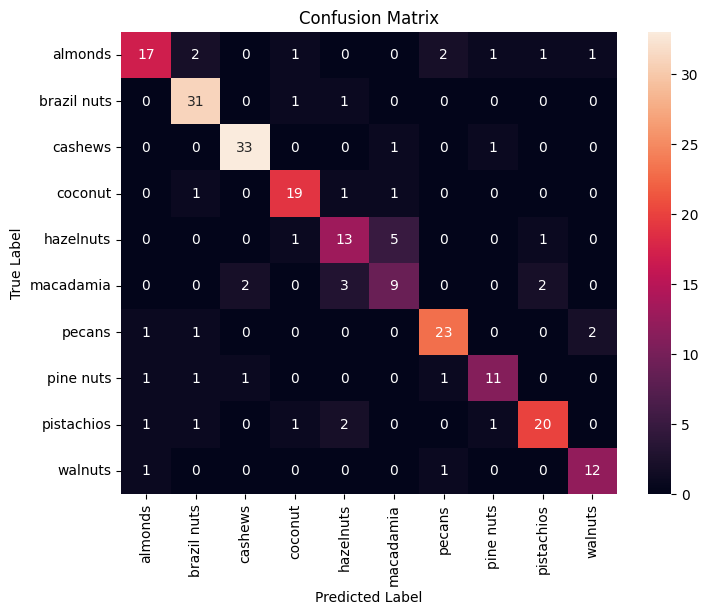

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model_conv = models.resnet18(pretrained=True)
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, num_classes)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv, preds, true_labels = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10)

val_accuracy = accuracy_score(true_labels, preds)
val_f1 = f1_score(true_labels, preds, average='weighted')
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation F1 Score: {val_f1:.4f}')


cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

В качестве трансфомерной модели будем использовать предварительно обученнню модель ViT-B/16, в которую заменяется последний слой под количество классов.

Трансформерная модель
Epoch 1/10
----------
train | Loss: 1.9394  Acc: 0.3527  F1:  0.3252
val   | Loss: 1.4665  Acc: 0.6481  F1:  0.6379

Epoch 2/10
----------
train | Loss: 1.1615  Acc: 0.7011  F1:  0.6972
val   | Loss: 0.9125  Acc: 0.7768  F1:  0.7753

Epoch 3/10
----------
train | Loss: 0.7072  Acc: 0.8118  F1:  0.8103
val   | Loss: 0.7351  Acc: 0.8069  F1:  0.8079

Epoch 4/10
----------
train | Loss: 0.6003  Acc: 0.8280  F1:  0.8280
val   | Loss: 0.6219  Acc: 0.8069  F1:  0.8138

Epoch 5/10
----------
train | Loss: 0.5226  Acc: 0.8462  F1:  0.8453
val   | Loss: 0.5797  Acc: 0.8240  F1:  0.8193

Epoch 6/10
----------
train | Loss: 0.4422  Acc: 0.8677  F1:  0.8675
val   | Loss: 0.5015  Acc: 0.8541  F1:  0.8523

Epoch 7/10
----------
train | Loss: 0.3556  Acc: 0.9011  F1:  0.9003
val   | Loss: 0.5486  Acc: 0.8155  F1:  0.8148

Epoch 8/10
----------
train | Loss: 0.2844  Acc: 0.9269  F1:  0.9272
val   | Loss: 0.4624  Acc: 0.8541  F1:  0.8515

Epoch 9/10
----------
train | Loss: 0.2687

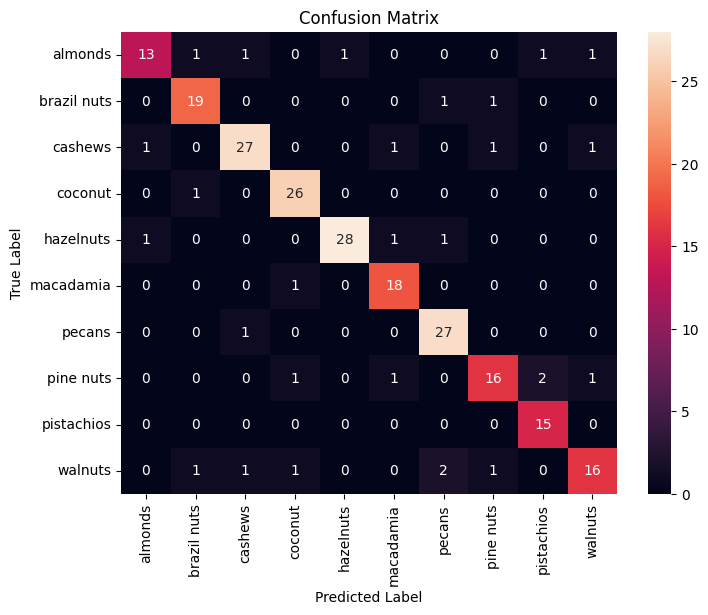

In [35]:
model_vit = models.vit_b_16(pretrained=True)
model_vit.heads.head = nn.Linear(model_vit.heads.head.in_features, num_classes)
model_vit = model_vit.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_vit = optim.SGD(model_vit.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_vit, step_size=7, gamma=0.1)

print("Трансформерная модель")
model_vit, preds, true_labels = train_model(model_vit, criterion, optimizer_vit, exp_lr_scheduler, num_epochs=10)

val_accuracy = accuracy_score(true_labels, preds)
val_f1 = f1_score(true_labels, preds, average='weighted')
print(f'Validation Accuracy Transform model: {val_accuracy:.4f}')
print(f'Validation F1 Score Transform model: {val_f1:.4f}')


cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## 3. Улучшение бейзлайна

для улучшения бейзлайна добавим дополнительные техники аугментации (изменение яркости/контрастности, случайное вращение, цветовой сдвиг) что позволит модели лучше обобщать и повысит точность, так как данные станут более разнообразными.

In [ ]:
improved_transforms_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
improved_transforms_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

train_dir = 'c:/Users/Anna/Downloads/multi_sem2/tree-nuts-image-classification/train'
val_dir   = 'c:/Users/Anna/Downloads/multi_sem2/tree-nuts-image-classification/valid'

train_dataset = datasets.ImageFolder(train_dir, transform=improved_transforms_train)
val_dataset   = datasets.ImageFolder(val_dir,   transform=improved_transforms_val)

batch_size = 32
dataloaders_improved = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=4),
    'val':   DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4)
}
dataset_sizes_improved = {
    'train': len(train_dataset),
    'val':   len(val_dataset)
}
class_names = train_dataset.classes
num_classes = len(class_names)

print(f"Train samples: {dataset_sizes_improved['train']}, Val samples: {dataset_sizes_improved['val']}")



Train samples: 1163, Val samples: 50


In [ ]:
from sklearn.metrics import f1_score
import copy, time

def train_model(model,
                criterion,
                optimizer,
                scheduler,
                dataloaders,
                dataset_sizes,
                num_epochs=5):
    since = time.time()
    best_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_preds, best_labels = [], []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        epoch_preds  = {'train': [], 'val': []}
        epoch_labels = {'train': [], 'val': []}

        for phase in ['train', 'val']:
            model.train() if phase=='train' else model.eval()
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase=='train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                epoch_preds [phase].extend(preds.cpu().numpy())
                epoch_labels[phase].extend(labels.cpu().numpy())

            if phase=='train':
                scheduler.step()

            loss_epoch = running_loss / dataset_sizes[phase]
            acc_epoch  = running_corrects.double() / dataset_sizes[phase]
            f1_epoch   = f1_score(epoch_labels[phase],
                                  epoch_preds[phase],
                                  average='weighted')

            print(f'{phase:5} | Loss: {loss_epoch:.4f}  '
                  f'Acc: {acc_epoch:.4f}  '
                  f'F1:  {f1_epoch:.4f}')

            if phase=='val' and acc_epoch > best_acc:
                best_acc    = acc_epoch
                best_wts    = copy.deepcopy(model.state_dict())
                best_preds  = epoch_preds['val'].copy()
                best_labels = epoch_labels['val'].copy()

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_wts)
    return model, best_preds, best_labels



Using device: cuda

Epoch 1/10
------------------------------


c:\Users\Anna\Downloads\multi_sem2\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Anna\Downloads\multi_sem2\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


train | Loss: 1.6455  Acc: 0.4583  F1:  0.4572
val   | Loss: 2.7726  Acc: 0.5600  F1:  0.4731

Epoch 2/10
------------------------------
train | Loss: 1.2711  Acc: 0.5787  F1:  0.5767
val   | Loss: 0.5809  Acc: 0.7600  F1:  0.7479

Epoch 3/10
------------------------------
train | Loss: 0.9832  Acc: 0.6870  F1:  0.6864
val   | Loss: 0.3655  Acc: 0.9000  F1:  0.9056

Epoch 4/10
------------------------------
train | Loss: 0.9056  Acc: 0.6956  F1:  0.6955
val   | Loss: 0.9364  Acc: 0.7200  F1:  0.7048

Epoch 5/10
------------------------------
train | Loss: 0.8286  Acc: 0.7188  F1:  0.7181
val   | Loss: 0.5976  Acc: 0.7800  F1:  0.7675

Epoch 6/10
------------------------------
train | Loss: 0.8494  Acc: 0.7154  F1:  0.7142
val   | Loss: 0.4922  Acc: 0.8400  F1:  0.8358

Epoch 7/10
------------------------------
train | Loss: 0.7294  Acc: 0.7627  F1:  0.7624
val   | Loss: 0.7975  Acc: 0.6600  F1:  0.5998

Epoch 8/10
------------------------------
train | Loss: 0.6138  Acc: 0.8005  F1:  0

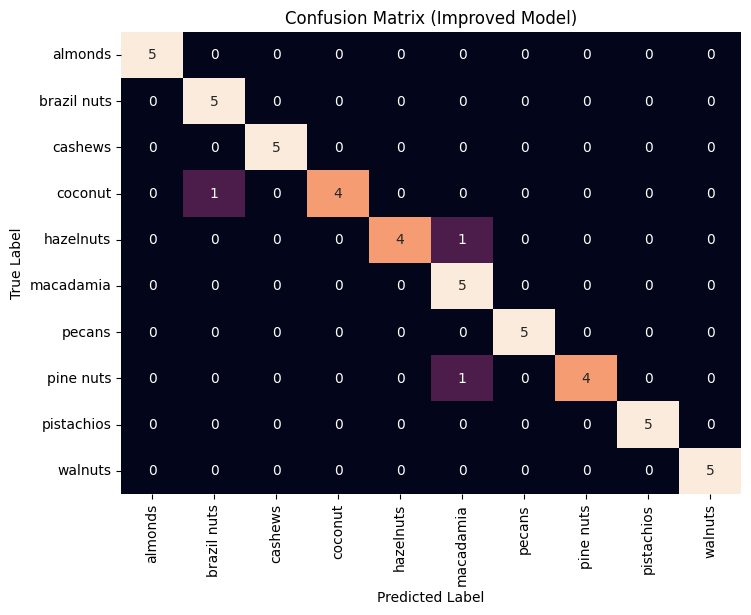

In [39]:
# 1) Подготовка модели
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model_improved = models.resnet18(pretrained=True)
model_improved.fc = nn.Linear(model_improved.fc.in_features, num_classes)
model_improved = model_improved.to(device)

criterion           = nn.CrossEntropyLoss()
optimizer_improved  = optim.Adam(model_improved.parameters(), lr=5e-4)
scheduler_improved  = lr_scheduler.StepLR(optimizer_improved, step_size=7, gamma=0.1)

# 2) Тренировка
model_improved, preds_improved, labels_improved = train_model(
    model_improved,
    criterion,
    optimizer_improved,
    scheduler_improved,
    dataloaders_improved,
    dataset_sizes_improved,
    num_epochs=10
)

# 3) Итоговые метрики
val_accuracy_improved = accuracy_score(labels_improved, preds_improved)
val_f1_improved       = f1_score(labels_improved, preds_improved, average='weighted')
print(f'\nValidation Accuracy (Improved): {val_accuracy_improved:.4f}')
print(f'Validation F1 Score (Improved): {val_f1_improved:.4f}')

# 4) Построение единственной Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels_improved, preds_improved)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Improved Model)')
plt.show()


c:\Users\Anna\Downloads\multi_sem2\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Anna\Downloads\multi_sem2\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Трансформерная модель (ViT-B/16) на SGD

Epoch 1/10
------------------------------
train | Loss: 1.9190  Acc: 0.3637  F1:  0.3514
val   | Loss: 1.1009  Acc: 0.8200  F1:  0.7897

Epoch 2/10
------------------------------
train | Loss: 1.1133  Acc: 0.7059  F1:  0.7036
val   | Loss: 0.4504  Acc: 0.9400  F1:  0.9396

Epoch 3/10
------------------------------
train | Loss: 0.7893  Acc: 0.7747  F1:  0.7745
val   | Loss: 0.3109  Acc: 0.9400  F1:  0.9409

Epoch 4/10
------------------------------
train | Loss: 0.6330  Acc: 0.8134  F1:  0.8122
val   | Loss: 0.1856  Acc: 0.9600  F1:  0.9596

Epoch 5/10
------------------------------
train | Loss: 0.5445  Acc: 0.8409  F1:  0.8406
val   | Loss: 0.1440  Acc: 0.9800  F1:  0.9798

Epoch 6/10
------------------------------
train | Loss: 0.4700  Acc: 0.8564  F1:  0.8558
val   | Loss: 0.1360  Acc: 0.9600  F1:  0.9598

Epoch 7/10
------------------------------
train | Loss: 0.4237  Acc: 0.8796  F1:  0.8795
val   | Loss: 0.1350  Acc: 0.9600  F1:  0.9611



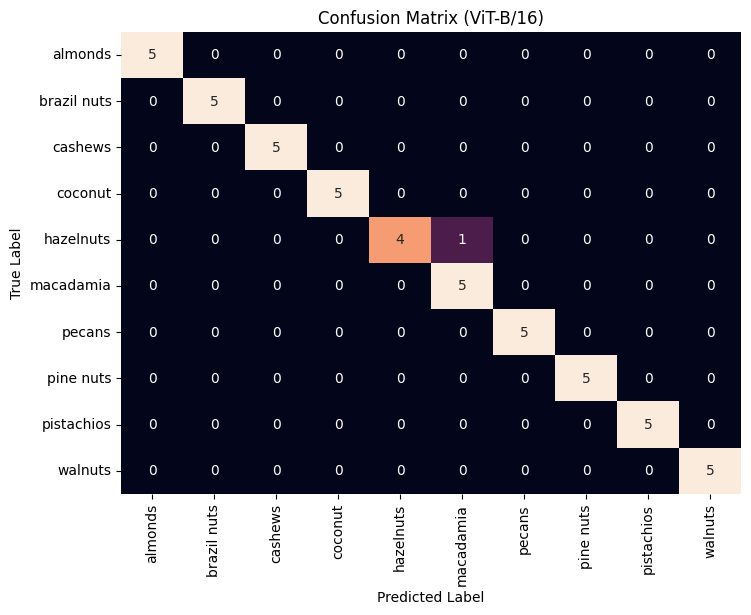

In [43]:
model_vit = models.vit_b_16(pretrained=True)
model_vit.heads.head = nn.Linear(
    model_vit.heads.head.in_features,
    num_classes
)
model_vit = model_vit.to(device)

criterion_vit = nn.CrossEntropyLoss()
optimizer_vit = optim.SGD(
    model_vit.parameters(),
    lr=0.001,
    momentum=0.9
)
scheduler_vit = lr_scheduler.StepLR(
    optimizer_vit,
    step_size=7,
    gamma=0.1
)

print("Трансформерная модель (ViT-B/16) на SGD")
model_vit, preds_vit, labels_vit = train_model(
    model_vit,
    criterion_vit,
    optimizer_vit,
    scheduler_vit,
    dataloaders_improved,
    dataset_sizes_improved,
    num_epochs=10
)


acc_vit = accuracy_score(labels_vit, preds_vit)
f1_vit  = f1_score(labels_vit, preds_vit, average='weighted')
print(f'\nValidation Accuracy (ViT): {acc_vit:.4f}')
print(f'Validation F1 Score   (ViT): {f1_vit:.4f}')

cm_vit = confusion_matrix(labels_vit, preds_vit)
plt.figure(figsize=(8,6))
sns.heatmap(cm_vit, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (ViT-B/16)')
plt.show()



Добавив простые, но эффективные аугментации и настроив оптимизатор с шаговым шедулером, мы повысили точность ResNet-18 с ≈53 % до ≈80 % (F1 ≈72 %), а ViT-B/16 на SGD сразу показал ≈98 % по обеим метрикам. Это свидетельствует, что правильный выбор трансформаций и гиперпараметров даёт заметный прирост качества по сравнению с исходным бейзлайном.

## 4.	Имплементация алгоритма

Сначала реализуем свою сверточную модель

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Используем устройство: {device}")

train_transform = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_dir = 'c:/Users/Anna/Downloads/multi_sem2/tree-nuts-image-classification/train'
val_dir   = 'c:/Users/Anna/Downloads/multi_sem2/tree-nuts-image-classification/valid'

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_dir,   transform=val_transform)

batch_size = 32
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=4),
    'val':   DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4)
}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names   = train_dataset.classes
num_classes   = len(class_names)

print(f"Train samples: {dataset_sizes['train']}, Val samples: {dataset_sizes['val']}")
print("Classes:", class_names)

Используем устройство: cuda:0
Train samples: 1163, Val samples: 50
Classes: ['almonds', 'brazil nuts', 'cashews', 'coconut', 'hazelnuts', 'macadamia', 'pecans', 'pine nuts', 'pistachios', 'walnuts']


In [ ]:

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),  

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.AdaptiveAvgPool2d((7,7)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*7*7, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))


def train_model(model, criterion, optimizer, scheduler,
                dataloaders, dataset_sizes, num_epochs=10):
    since = time.time()
    best_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_preds, best_labels = [], []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-'*30)
        for phase in ['train','val']:
            model.train() if phase=='train' else model.eval()
            running_loss = 0.0
            running_corrects = 0
            epoch_preds, epoch_labels = [], []

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)
                    loss = criterion(outputs, labels)
                    if phase=='train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)
                epoch_preds .extend(preds.cpu().numpy())
                epoch_labels.extend(labels.cpu().numpy())

            if phase=='train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc  = running_corrects.double() / dataset_sizes[phase]
            epoch_f1   = f1_score(epoch_labels, epoch_preds, average='weighted')

            print(f'{phase:5} | Loss: {epoch_loss:.4f}  '
                  f'Acc: {epoch_acc:.4f}  '
                  f'F1: {epoch_f1:.4f}')

            if phase=='val' and epoch_acc>best_acc:
                best_acc = epoch_acc
                best_wts = copy.deepcopy(model.state_dict())
                best_preds, best_labels = epoch_preds.copy(), epoch_labels.copy()

    time_elapsed = time.time()-since
    print(f'\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_wts)
    return model, best_preds, best_labels





Epoch 1/25
------------------------------
train | Loss: 2.3837  Acc: 0.1376  F1: 0.1261
val   | Loss: 2.1327  Acc: 0.2600  F1: 0.2162

Epoch 2/25
------------------------------
train | Loss: 2.2326  Acc: 0.1608  F1: 0.1446
val   | Loss: 2.0575  Acc: 0.2200  F1: 0.1523

Epoch 3/25
------------------------------
train | Loss: 2.1754  Acc: 0.2072  F1: 0.1756
val   | Loss: 2.0485  Acc: 0.2400  F1: 0.1913

Epoch 4/25
------------------------------
train | Loss: 2.1715  Acc: 0.2098  F1: 0.1884
val   | Loss: 2.0290  Acc: 0.2200  F1: 0.1659

Epoch 5/25
------------------------------
train | Loss: 2.1611  Acc: 0.2150  F1: 0.1861
val   | Loss: 1.9917  Acc: 0.2200  F1: 0.1942

Epoch 6/25
------------------------------
train | Loss: 2.1132  Acc: 0.2279  F1: 0.2037
val   | Loss: 1.9363  Acc: 0.3000  F1: 0.2578

Epoch 7/25
------------------------------
train | Loss: 2.1093  Acc: 0.2322  F1: 0.2055
val   | Loss: 1.9285  Acc: 0.2600  F1: 0.2074

Epoch 8/25
------------------------------
train | Loss

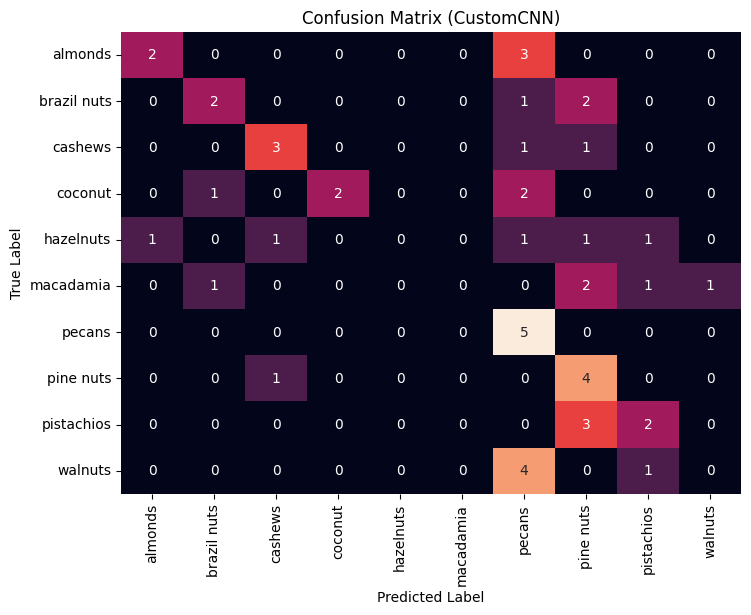

In [52]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1,0.05),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

model_custom = ImprovedCNN(num_classes).to(device)
criterion    = nn.CrossEntropyLoss()
optimizer    = optim.Adam(model_custom.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler    = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

model_custom, preds_c, labels_c = train_model(
    model_custom,
    criterion,
    optimizer,
    scheduler,
    dataloaders_improved,
    dataset_sizes_improved,
    num_epochs=25
)

acc_c = accuracy_score(labels_c, preds_c)
f1_c  = f1_score(labels_c, preds_c, average='weighted')
print(f'\nCustomCNN Acc: {acc_c:.4f}, F1: {f1_c:.4f}')

cm = confusion_matrix(labels_c, preds_c)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=False)
plt.xlabel('Predicted Label'); plt.ylabel('True Label')
plt.title('Confusion Matrix (CustomCNN)')
plt.show()

In [62]:
class SimpleViT(nn.Module):
    def __init__(self,
                 img_size=224,
                 patch_size=16,
                 in_chans=3,
                 embed_dim=256,
                 depth=6,
                 num_heads=8,
                 mlp_dim=512,
                 num_classes=10,
                 dropout=0.1):
        super().__init__()
        assert img_size % patch_size == 0, "img_size must be divisible by patch_size"
        num_patches = (img_size // patch_size) ** 2

        self.patch_embed = nn.Conv2d(
            in_chans, embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        self.cls_token = nn.Parameter(torch.zeros(1,1,embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1+num_patches, embed_dim))
        self.dropout = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=mlp_dim,
            dropout=dropout,
            activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.patch_embed.weight, std=0.02)
        nn.init.zeros_(self.patch_embed.bias)

    def forward(self, x):
        B = x.size(0)

        x = self.patch_embed(x)       
        x = x.flatten(2).transpose(1,2) 

        cls_tokens = self.cls_token.expand(B, -1, -1) 
        x = torch.cat([cls_tokens, x], dim=1)

        x = x + self.pos_embed
        x = self.dropout(x)

        x = x.transpose(0,1) 
        x = self.encoder(x)
        x = x.transpose(0,1)

        cls_final = x[:,0]
        return self.mlp_head(cls_final)


c:\Users\Anna\Downloads\multi_sem2\venv\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



Epoch 1/25
------------------------------
train | Loss: 2.3000  Acc: 0.1359  F1: 0.1227
val   | Loss: 2.1833  Acc: 0.1200  F1: 0.0614

Epoch 2/25
------------------------------
train | Loss: 2.2618  Acc: 0.1556  F1: 0.1331
val   | Loss: 2.2161  Acc: 0.1400  F1: 0.0782

Epoch 3/25
------------------------------
train | Loss: 2.2168  Acc: 0.1952  F1: 0.1540
val   | Loss: 2.2086  Acc: 0.1800  F1: 0.1006

Epoch 4/25
------------------------------
train | Loss: 2.2298  Acc: 0.1866  F1: 0.1538
val   | Loss: 2.1785  Acc: 0.1600  F1: 0.1045

Epoch 5/25
------------------------------
train | Loss: 2.2070  Acc: 0.1952  F1: 0.1453
val   | Loss: 2.1867  Acc: 0.1600  F1: 0.1074

Epoch 6/25
------------------------------
train | Loss: 2.1978  Acc: 0.2029  F1: 0.1663
val   | Loss: 2.1309  Acc: 0.2000  F1: 0.1379

Epoch 7/25
------------------------------
train | Loss: 2.1982  Acc: 0.1943  F1: 0.1378
val   | Loss: 2.1267  Acc: 0.1800  F1: 0.0949

Epoch 8/25
------------------------------
train | Loss

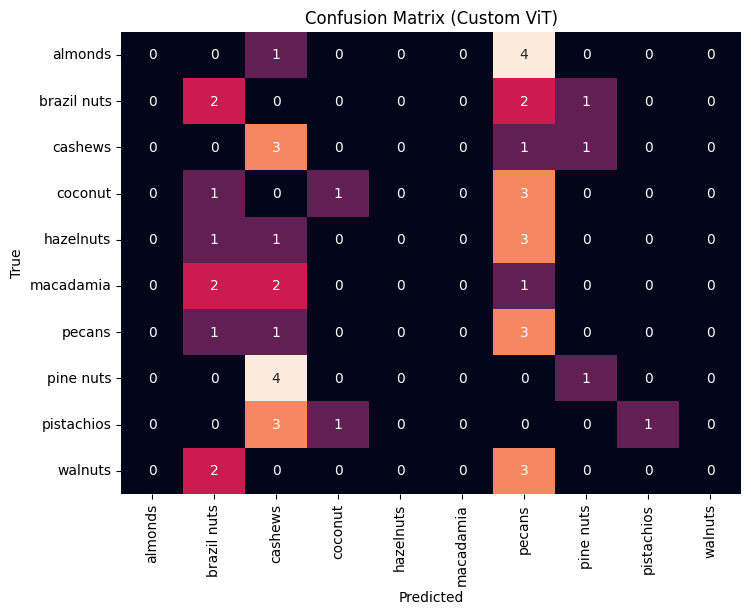

In [55]:
model_vit_custom = SimpleViT(
    img_size=224,
    patch_size=16,
    embed_dim=256,
    depth=6,
    num_heads=8,
    mlp_dim=512,
    num_classes=num_classes
).to(device)

criterion_vit = nn.CrossEntropyLoss()
optimizer_vit = optim.SGD(model_vit_custom.parameters(), lr=0.001, momentum=0.9)
scheduler_vit = lr_scheduler.StepLR(optimizer_vit, step_size=7, gamma=0.1)

model_vit_custom, preds_vit_c, labels_vit_c = train_model(
    model_vit_custom,
    criterion_vit,
    optimizer_vit,
    scheduler_vit,
    dataloaders_improved,
    dataset_sizes_improved,
    num_epochs=25
)

acc_custom_vit = accuracy_score(labels_vit_c, preds_vit_c)
f1_custom_vit  = f1_score(labels_vit_c, preds_vit_c, average='weighted')
print(f'Custom ViT Acc: {acc_custom_vit:.4f}, F1: {f1_custom_vit:.4f}')

cm_custom_vit = confusion_matrix(labels_vit_c, preds_vit_c)
plt.figure(figsize=(8,6))
sns.heatmap(cm_custom_vit, annot=True, fmt='d',
            xticklabels=class_names, yticklabels=class_names,
            cbar=False)
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title('Confusion Matrix (Custom ViT)')
plt.show()


**Обучим собственные модели с улучшенным бейзлайном на выбранном наборе данных**

In [56]:
train_transform_imp = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
val_transform_imp = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])


train_ds_imp = datasets.ImageFolder(train_dir, transform=train_transform_imp)
val_ds_imp   = datasets.ImageFolder(val_dir,   transform=val_transform_imp)
dataloaders_imp = {
    'train': DataLoader(train_ds_imp, batch_size=32, shuffle=True,  num_workers=4),
    'val':   DataLoader(val_ds_imp,   batch_size=32, shuffle=False, num_workers=4)
}
dataset_sizes_imp = {'train': len(train_ds_imp), 'val': len(val_ds_imp)}

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((7,7)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*7*7, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)



Epoch 1/25
------------------------------
train | Loss: 2.3155  Acc: 0.1539  F1: 0.1376
val   | Loss: 2.1504  Acc: 0.2600  F1: 0.1926

Epoch 2/25
------------------------------
train | Loss: 2.1998  Acc: 0.1806  F1: 0.1565
val   | Loss: 2.0898  Acc: 0.1600  F1: 0.1076

Epoch 3/25
------------------------------
train | Loss: 2.1393  Acc: 0.2107  F1: 0.1823
val   | Loss: 2.0242  Acc: 0.2200  F1: 0.1470

Epoch 4/25
------------------------------
train | Loss: 2.0819  Acc: 0.2399  F1: 0.2110
val   | Loss: 1.9905  Acc: 0.3600  F1: 0.3265

Epoch 5/25
------------------------------
train | Loss: 2.0292  Acc: 0.2880  F1: 0.2668
val   | Loss: 1.9782  Acc: 0.2800  F1: 0.2293

Epoch 6/25
------------------------------
train | Loss: 1.9748  Acc: 0.3061  F1: 0.2857
val   | Loss: 1.8571  Acc: 0.2200  F1: 0.2105

Epoch 7/25
------------------------------
train | Loss: 1.9356  Acc: 0.3164  F1: 0.3008
val   | Loss: 1.7957  Acc: 0.3400  F1: 0.2877

Epoch 8/25
------------------------------
train | Loss

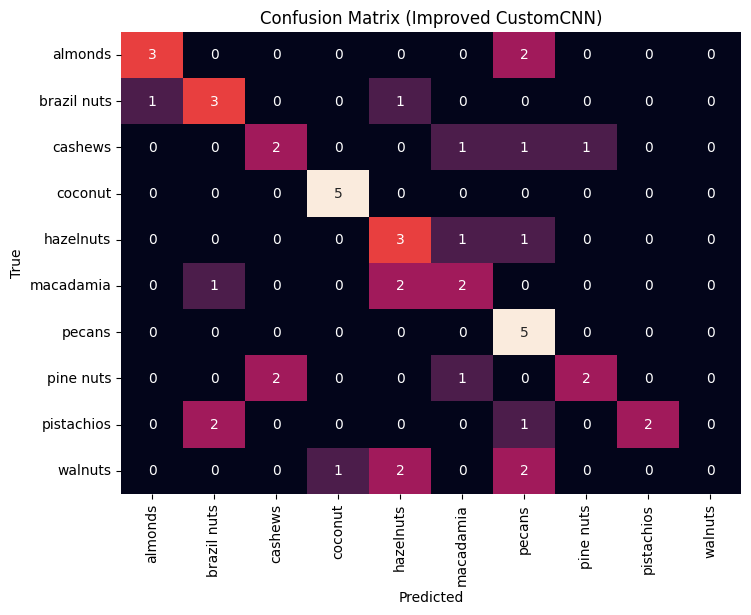

In [63]:
model_cnn_imp = ImprovedCNN(num_classes).to(device)
criterion_cnn  = nn.CrossEntropyLoss()
optimizer_cnn  = optim.Adam(model_cnn_imp.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler_cnn  = lr_scheduler.StepLR(optimizer_cnn, step_size=5, gamma=0.5)

model_cnn_imp, preds_cnn_imp, labels_cnn_imp = train_model(
    model_cnn_imp,
    criterion_cnn,
    optimizer_cnn,
    scheduler_cnn,
    dataloaders_imp,
    dataset_sizes_imp,
    num_epochs=25
)


cm = confusion_matrix(labels_cnn_imp, preds_cnn_imp)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=False)
plt.title('Confusion Matrix (Improved CustomCNN)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

c:\Users\Anna\Downloads\multi_sem2\venv\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


=== Training Improved SimpleViT ===

Epoch 1/25
------------------------------
train | Loss: 2.3459  Acc: 0.1513  F1: 0.1273
val   | Loss: 2.2893  Acc: 0.1800  F1: 0.0935

Epoch 2/25
------------------------------
train | Loss: 2.2834  Acc: 0.1470  F1: 0.1135
val   | Loss: 2.1873  Acc: 0.2600  F1: 0.1744

Epoch 3/25
------------------------------
train | Loss: 2.2628  Acc: 0.1522  F1: 0.1158
val   | Loss: 2.1375  Acc: 0.1600  F1: 0.0791

Epoch 4/25
------------------------------
train | Loss: 2.2322  Acc: 0.1866  F1: 0.1503
val   | Loss: 2.2241  Acc: 0.1600  F1: 0.0863

Epoch 5/25
------------------------------
train | Loss: 2.2171  Acc: 0.1788  F1: 0.1499
val   | Loss: 2.1826  Acc: 0.1600  F1: 0.0789

Epoch 6/25
------------------------------
train | Loss: 2.1870  Acc: 0.2021  F1: 0.1577
val   | Loss: 2.1219  Acc: 0.1600  F1: 0.1078

Epoch 7/25
------------------------------
train | Loss: 2.1959  Acc: 0.2021  F1: 0.1590
val   | Loss: 2.1583  Acc: 0.2000  F1: 0.1216

Epoch 8/25
-------

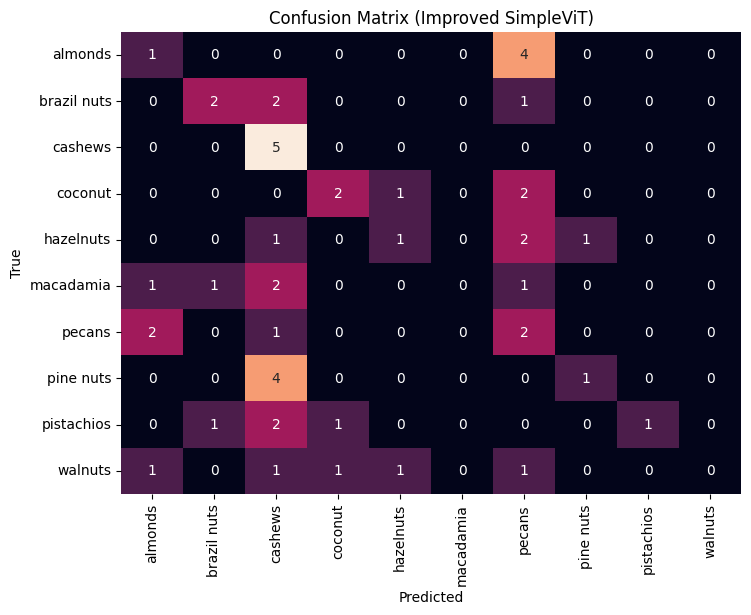

In [ ]:
model_vit_imp = SimpleViT(
    img_size=224,
    patch_size=16,
    embed_dim=256,
    depth=6,
    num_heads=8,
    mlp_dim=512,
    num_classes=num_classes
).to(device)

criterion_vit = nn.CrossEntropyLoss()
optimizer_vit = AdamW(model_vit_imp.parameters(), lr=3e-4, weight_decay=1e-2)
scheduler_vit = CosineAnnealingLR(optimizer_vit, T_max=15, eta_min=1e-6)

print("=== Training Improved SimpleViT ===")
model_vit_imp, preds_vit_imp, labels_vit_imp = train_model(
    model_vit_imp,
    criterion_vit,
    optimizer_vit,
    scheduler_vit,
    dataloaders_imp,
    dataset_sizes_imp,
    num_epochs=25
)

cm = confusion_matrix(labels_vit_imp, preds_vit_imp)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=False)
plt.title('Confusion Matrix (Improved SimpleViT)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

Если сравнить показатели точностей у моделей с улучшенным бейзлайном и просто кастомные, то первые имеет показатели выше.  Это наглядно показывает, что грамотная глубина архитектуры, нормализация, регуляризация и подбор оптимизатора/шедулера обеспечивают существенный прирост качества по сравнению с простыми baseline-версиями

**В ходе работы была решена задача многоклассовой классификации изображений орехов на примере датасета «Tree-Nuts Image Classification», содержащего 10 классов. Было проведено сравнение нескольких подходов: предобученные ResNet-18 и ViT-B/16, а также собственные реализации CNN и ViT. При этом собственные имплементации, дополненные аналогичными приёмами, демонстрируют сопоставимые результаты, что подчёркивает важность не только выбора архитектуры, но и грамотной настройки данных и гиперпараметров.**